# Data Science Олимпиада

[Ссылка](https://contest.sdsj.ru/#/data?_k=nb68yz) на соревнование


При выполнении данной работы были использованы следующие *источники*:
    
1) А. Дьяконов. ["Анализ данных в задаче Сбербанк. Примеры визуализации"](https://github.com/Dyakonov/case_sdsj/blob/master/dj_sdsj01_visual.ipynb)

2) Базовые решения со [страницы](https://contest.sdsj.ru/#/data?_k=nb68yz) соревнования

---


# Задача А. Предсказание пола клиента

## Описание
Необходимо предсказать вероятность пола 1 для каждого *customer_id*, которого нет в обучающей выборке *customers_gender_train.csv*, но есть в *transactions.csv*.

In [2]:
import pandas as pd
import numpy as np

%pylab inline
pd.set_option('display.mpl_style', 'default')
figsize(12, 9)

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


## Загрузка данных

In [2]:
transactions = pd.read_csv("transactions.csv")
print(transactions.shape)
transactions.head()

(6849346, 6)


,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id
0,39026145,0 10:23:26,4814,1030,-2245.92,NaN
1,39026145,1 10:19:29,6011,7010,56147.89,NaN
2,39026145,1 10:20:56,4829,2330,-56147.89,NaN
3,39026145,1 10:39:54,5499,1010,-1392.47,NaN
4,39026145,2 15:33:42,5499,1010,-920.83,NaN


In [3]:
customers_gender_train = pd.read_csv("customers_gender_train.csv")
print(customers_gender_train.shape)
customers_gender_train.head()

(12000, 2)


,customer_id,gender
0,75562265,0
1,10928546,1
2,69348468,1
3,84816985,1
4,61009479,0


In [4]:
tr_types = pd.read_csv("tr_types.csv", sep=';')
print(tr_types.shape, transactions.tr_type.nunique())
tr_types.head()

(155, 2) 77


,tr_type,tr_description
0,3200,Плата за предоставление услуг посредством моби...
1,3210,Плата за предоставление отчета по счету карты ...
2,3800,Плата за обслуживание банковской карты (за пер...
3,4000,Плата за получение наличных в Сбербанке
4,4001,Плата за получение наличных в Сбербанке (в дру...


In [5]:
tr_mcc_codes = pd.read_csv("tr_mcc_codes.csv", sep=';')
print(tr_mcc_codes.shape, transactions.mcc_code.nunique())
tr_mcc_codes.head()

(184, 2) 184


,mcc_code,mcc_description
0,742,Ветеринарные услуги
1,1711,"Генеральные подрядчики по вентиляции, теплосна..."
2,1731,Подрядчики по электричеству
3,1799,"Подрядчики, специализированная торговля — нигд..."
4,2741,Разнообразные издательства/печатное дело


## Формирование "базовой" матрицы признаков

In [6]:
# присоедниение пола
transactions = pd.merge(transactions, customers_gender_train, on='customer_id', how='outer')
print (transactions.shape)
transactions.head()

(6849346, 7)


,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id,gender
0,39026145,0 10:23:26,4814,1030,-2245.92,NaN,1.0
1,39026145,1 10:19:29,6011,7010,56147.89,NaN,1.0
2,39026145,1 10:20:56,4829,2330,-56147.89,NaN,1.0
3,39026145,1 10:39:54,5499,1010,-1392.47,NaN,1.0
4,39026145,2 15:33:42,5499,1010,-920.83,NaN,1.0


## Исследование датасета

In [9]:
# удаляем бесполезную "айдишку терминала"
del transactions['term_id']

In [10]:
# группируем юзеров и суммируем количество на(-от)числений
X_amount = transactions[['customer_id','amount']].groupby('customer_id').sum()
X_amount.head()

,amount
customer_id,
6815,-1249454.87
22899,-629796.59
27914,-2977026.82
28753,-26546282.86
31385,-2180003.58


In [11]:
transactions.count(axis=0)

customer_id    6849346
mcc_code       6849346
tr_type        6849346
amount         6849346
gender         5393337
num_day        6849346
hour           6849346
minute         6849346
second         6849346
dayofweek      6849346
dtype: int64

Видим, что пропущенные значения присутствуют только в столбце gender.

### Популярные типы транзакций

,tr_type,amount,tr_description
0,1010,1589734,Покупка. POS ТУ СБ РФ
1,2010,1040713,Выдача наличных в АТМ Сбербанк России
2,1030,970994,Оплата услуги. Банкоматы СБ РФ
3,1110,928154,Покупка. POS ТУ Россия
4,7070,691896,Перевод на карту (с карты) через Мобильный бан...
5,2370,376521,Списание с карты на карту по операции <перевод...
6,7010,258088,Взнос наличных через АТМ (в своем тер.банке)
7,7030,155200,Перевод на карту (с карты) через АТМ (в предел...
8,1100,117870,Покупка. ТУ Россия
9,7071,96146,Перевод на карту (с карты) через Мобильный бан...


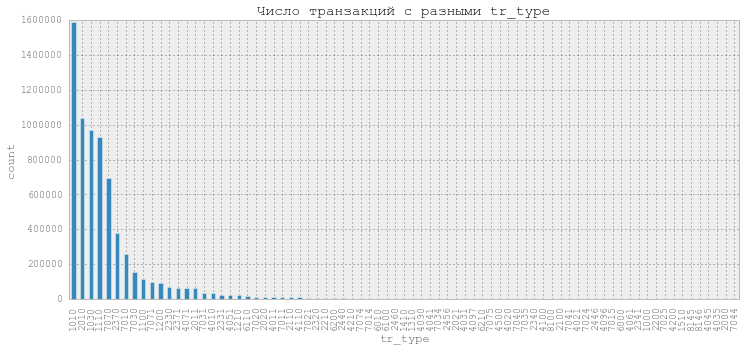

In [12]:
# Самые популярные tr_types
tmp = transactions.groupby('tr_type').amount.count()
tmp.sort(ascending=False)
figsize(12, 5)
tmp.plot(kind='bar')
plt.xlabel('tr_type')
plt.ylabel('count')
plt.title(u'Число транзакций с разными tr_type')
pd.merge(tmp[:15].reset_index(), tr_types)

In [13]:
# Гендерные tr_types

tmp = pd.merge(pd.crosstab(transactions.tr_type, transactions.gender).reset_index(), tr_types)
#tmp[:5]
abs(tmp[0.0] - tmp[1.0])/(tmp[0.0] + tmp[1.0])
tmp['k'] = (abs(tmp[0.0] - tmp[1.0])/(tmp[0.0] + tmp[1.0]))

tmp = tmp[(tmp[0.0] + tmp[1.0]) > 50] # достаточно статистики


tmp.sort('k',  ascending=False, inplace=True)
tmp.columns = [u'tr_type', u'ж', u'м', u'tr_type_description', u'k']
tmp.set_index(tmp.tr_type, inplace=True)
del tmp['tr_type']
tmp[:15]

,ж,м,tr_type_description,k
tr_type,,,,
6210,39,377,Возврат покупки.POS Зарубеж. ТУ,0.812500
8100,107,15,Списание после проведения претензионной работы,0.754098
1310,130,749,н/д,0.704209
7075,58,332,Перевод с карты на карту в овердрафте через Мо...,0.702564
7034,518,138,Перевод на карту/ с карты через АТМ (без взима...,0.579268
1410,240,854,н/д,0.561243
7035,52,119,Перевод на карту/ с карты через АТМ (со взиман...,0.391813
6200,2183,1150,Возврат покупки. Зарубеж. ТУ,0.309931
4100,77,41,Плата за получение наличных. Россия,0.305085


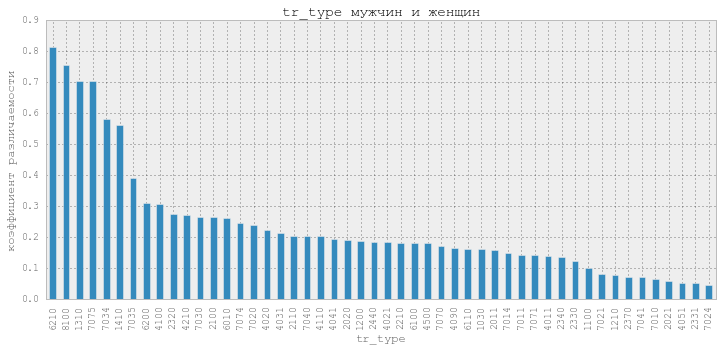

In [14]:
p = tmp[:50].k.plot(kind='bar')
p.set_ylabel(u'коэффициент различаемости')
p.set_title(u'tr_type мужчин и женщин')

### Преобразование категориальных признаков

#### Mcc_codes

In [15]:
X_mcc = transactions.groupby('customer_id').apply(lambda x: x[['mcc_code']].unstack().value_counts()).unstack().fillna(0)

In [16]:
X_mcc.head()

,742,1711,1731,1799,2741,3000,3351,3501,4111,4112,...,8299,8398,8641,8699,8999,9211,9222,9311,9399,9402
customer_id,,,,,,,,,,,,,,,,,,,,,
6815,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22899,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27914,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28753,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
31385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Tr_type

In [17]:
X_tr = transactions.groupby('customer_id').apply(lambda x: x[['tr_type']].unstack().value_counts()).unstack().fillna(0)
X_tr.head()

,1000,1010,1030,1100,1110,1200,1210,1310,1410,1510,...,7040,7041,7044,7070,7071,7074,7075,8100,8145,8146
customer_id,,,,,,,,,,,,,,,,,,,,,
6815,0.0,42.0,90.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22899,0.0,6.0,47.0,0.0,27.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,9.0,3.0,0.0,1.0,0.0,0.0,0.0
27914,0.0,0.0,58.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28753,0.0,89.0,25.0,3.0,65.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0
31385,0.0,75.0,125.0,0.0,75.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Объединяем признаки в одну таблицу

In [18]:
X = pd.concat((X_amount, X_tr, X_mcc), axis=1)

In [19]:
X = (X - X.mean()) / X.std() # Нормировка

In [20]:
X.head()

,amount,1000,1010,1030,1100,1110,1200,1210,1310,1410,...,8299,8398,8641,8699,8999,9211,9222,9311,9399,9402
customer_id,,,,,,,,,,,,,,,,,,,,,
6815,0.245514,-0.0322,-0.460164,0.252261,-0.292061,-0.515492,-0.177320,-0.120484,-0.032707,-0.035128,...,-0.0733,-0.053779,-0.089966,-0.0221,-0.219527,-0.018977,-0.077383,-0.059304,-0.112485,-0.036332
22899,0.264225,-0.0322,-0.719078,-0.177042,-0.292061,-0.409754,-0.148008,-0.120484,-0.032707,-0.035128,...,-0.0733,-0.053779,-0.089966,-0.0221,-0.219527,-0.018977,-0.077383,-0.059304,-0.112485,-0.036332
27914,0.193349,-0.0322,-0.762230,-0.067220,-0.292061,-0.715218,-0.118697,-0.120484,-0.032707,-0.035128,...,-0.0733,-0.053779,-0.089966,-0.0221,-0.219527,-0.018977,-0.077383,-0.059304,-0.112485,-0.036332
28753,-0.518329,-0.0322,-0.122137,-0.396686,-0.180559,0.036692,-0.177320,-0.120484,-0.032707,-0.035128,...,-0.0733,-0.053779,-0.089966,-0.0221,0.056365,-0.018977,-0.077383,-0.059304,-0.112485,-0.036332
31385,0.217416,-0.0322,-0.222826,0.601695,-0.292061,0.154177,-0.177320,-0.120484,-0.032707,-0.035128,...,-0.0733,-0.053779,-0.089966,-0.0221,-0.219527,-0.018977,-0.077383,-0.059304,-0.112485,-0.036332


### Формирование обучаещей и тестовой выборки

Выносим целевую переменную $-$ пол клиента

In [54]:
customers_gender = customers_gender_train.set_index('customer_id')
Y_train = customers_gender.loc[X.index].gender
Y_train = Y_train.reset_index()
del Y_train['customer_id']
Y_train = Y_train.dropna(0)
Y_train.head()

,gender
0,0.0
1,1.0
2,1.0
3,0.0
4,0.0


Обучающее множество

In [58]:
X_train = X.reset_index()
X_train = X_train.loc[Y_train.index].set_index('customer_id')
X_train.head()

,amount,1000,1010,1030,1100,1110,1200,1210,1310,1410,...,8299,8398,8641,8699,8999,9211,9222,9311,9399,9402
customer_id,,,,,,,,,,,,,,,,,,,,,
6815,0.245514,-0.0322,-0.460164,0.252261,-0.292061,-0.515492,-0.177320,-0.120484,-0.032707,-0.035128,...,-0.0733,-0.053779,-0.089966,-0.0221,-0.219527,-0.018977,-0.077383,-0.059304,-0.112485,-0.036332
22899,0.264225,-0.0322,-0.719078,-0.177042,-0.292061,-0.409754,-0.148008,-0.120484,-0.032707,-0.035128,...,-0.0733,-0.053779,-0.089966,-0.0221,-0.219527,-0.018977,-0.077383,-0.059304,-0.112485,-0.036332
27914,0.193349,-0.0322,-0.762230,-0.067220,-0.292061,-0.715218,-0.118697,-0.120484,-0.032707,-0.035128,...,-0.0733,-0.053779,-0.089966,-0.0221,-0.219527,-0.018977,-0.077383,-0.059304,-0.112485,-0.036332
28753,-0.518329,-0.0322,-0.122137,-0.396686,-0.180559,0.036692,-0.177320,-0.120484,-0.032707,-0.035128,...,-0.0733,-0.053779,-0.089966,-0.0221,0.056365,-0.018977,-0.077383,-0.059304,-0.112485,-0.036332
31385,0.217416,-0.0322,-0.222826,0.601695,-0.292061,0.154177,-0.177320,-0.120484,-0.032707,-0.035128,...,-0.0733,-0.053779,-0.089966,-0.0221,-0.219527,-0.018977,-0.077383,-0.059304,-0.112485,-0.036332


Тестовое множество

In [69]:
X_test = X.drop(customers_gender.index)
X_test.head()

,amount,1000,1010,1030,1100,1110,1200,1210,1310,1410,...,8299,8398,8641,8699,8999,9211,9222,9311,9399,9402
customer_id,,,,,,,,,,,,,,,,,,,,,
49101,0.222356,-0.0322,-0.683117,-0.606346,-0.292061,-0.679972,-0.17732,-0.120484,-0.032707,-0.035128,...,-0.0733,-0.053779,-0.089966,-0.0221,-0.219527,-0.018977,-0.077383,-0.059304,-0.112485,-0.036332
114348,0.054500,-0.0322,1.639916,-0.496524,-0.292061,0.024943,-0.17732,-0.120484,-0.032707,-0.035128,...,-0.0733,-0.053779,-0.089966,-0.0221,1.021988,-0.018977,-0.077383,-0.059304,-0.112485,-0.036332
127946,0.214843,-0.0322,-0.604005,-0.646281,-0.292061,-0.609480,-0.17732,-0.120484,-0.032707,-0.035128,...,-0.0733,-0.053779,-0.089966,-0.0221,-0.219527,-0.018977,-0.077383,-0.059304,-0.112485,-0.036332
137367,-0.130148,-0.0322,-0.747846,0.202342,-0.292061,-0.715218,-0.17732,-0.120484,-0.032707,-0.035128,...,-0.0733,-0.053779,-0.089966,-0.0221,-0.219527,-0.018977,-0.077383,-0.059304,-0.112485,-0.036332
174467,0.183996,-0.0322,-0.337899,-0.007317,-0.292061,-0.092543,-0.17732,-0.120484,-0.032707,-0.035128,...,-0.0733,-0.053779,-0.089966,-0.0221,0.608149,-0.018977,-0.077383,-0.059304,-0.112485,-0.036332


## Построение моделей. Валидация

In [128]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV

Построим две модели: RandomForestClassifier и GradientBoostingClassifier. Результаты предсказания усредним. Чтобы избежать переобучения моделей, проведем перекрестную проверку.

In [97]:
X_1, X_2, y_1, y_2 = train_test_split(X_train, Y_train, test_size=0.4) # Разбиваем трэйн для валидации

In [121]:
clf_1 = RandomForestClassifier(n_estimators=1000)
clf_1.fit(X_1, y_1)
clf_1.score(X_2, y_2)

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


0.78312499999999996

In [154]:
clf_2 = GradientBoostingClassifier(n_estimators=1000)
clf_2.fit(X_1, y_1)
clf_2.score(X_2, y_2)

C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7845833333333333

In [134]:
"""parameters = {'n_estimators':[50, 150, 300, 1000], 'max_depth':[2, 3, 5]}
gbm = GradientBoostingClassifier()
grid = GridSearchCV(gbm, parameters, verbose=1)"""

## Обучение моделей. Предсказание результата

In [155]:
clf_1.fit(X_train, Y_train)
clf_2.fit(X_train, Y_train)
result = pd.DataFrame(X_test.index, columns=['customer_id'])
pred_1 = clf_1.predict_proba(X_test)[:, 1]
pred_2 = clf_2.predict_proba(X_test)[:, 1]
result['gender'] = (pred_1 + pred_2) / 2
result.to_csv('solution_a.csv', index=False)

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [156]:
result.head()

,customer_id,gender
0,49101,0.673994
1,114348,0.690714
2,127946,0.845780
3,137367,0.514909
4,174467,0.779287


# Задача B. Предсказание объема трат по категориям

## Описание
Необходимо предсказать объем трат по каждой из $184$ категорий на каждый день следующего месяца. Итоговый файл должен содержать предсказания по $184 * 30 = 5520$ объектам. Объем трат в конкретной категории считается как сумма всех расходных транзакций в текущей категории по всем пользователям.

## Подготовка данных

### Обучающее и тестововое множество

Будем работать с транзакциями, по которым amount<0 (расходы клиента).

In [3]:
transactions = pd.read_csv('transactions.csv')
train_transactions = transactions[transactions.amount < 0].copy()
train_transactions['day'] = train_transactions.tr_datetime.apply(lambda dt: dt.split()[0]).astype(int)

In [4]:
train_transactions.head()

,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id,day
0,39026145,0 10:23:26,4814,1030,-2245.92,NaN,0
2,39026145,1 10:20:56,4829,2330,-56147.89,NaN,1
3,39026145,1 10:39:54,5499,1010,-1392.47,NaN,1
4,39026145,2 15:33:42,5499,1010,-920.83,NaN,2
5,39026145,2 15:53:49,5541,1010,-14643.37,NaN,2


In [5]:
train_grid = pd.DataFrame(columns=train_transactions.mcc_code.unique(), 
                          index=train_transactions.day.unique())
train_grid = train_grid.unstack().reset_index().dropna(axis=1)
train_grid.columns = ['mcc_code', 'day']

train_grid.head()

,mcc_code,day
0,4814,0
1,4814,1
2,4814,2
3,4814,3
4,4814,4


In [6]:
train_grid.shape

(84088, 2)

In [7]:
test_transactions = pd.DataFrame(columns=train_transactions.mcc_code.unique(), 
                                 index=np.arange(1, 31) + train_transactions.day.max())
test_transactions = test_transactions.unstack().reset_index().dropna(axis=1)
test_transactions.columns = ['mcc_code', 'day']

test_transactions.head()

,mcc_code,day
0,4814,457
1,4814,458
2,4814,459
3,4814,460
4,4814,461


In [8]:
test_transactions.shape

(5520, 2)

In [9]:
train_transactions.head()

,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id,day
0,39026145,0 10:23:26,4814,1030,-2245.92,NaN,0
2,39026145,1 10:20:56,4829,2330,-56147.89,NaN,1
3,39026145,1 10:39:54,5499,1010,-1392.47,NaN,1
4,39026145,2 15:33:42,5499,1010,-920.83,NaN,2
5,39026145,2 15:53:49,5541,1010,-14643.37,NaN,2


#### Временн*ы*е признаки

In [10]:
for tr_table in [train_transactions, test_transactions, train_grid]:
    tr_table['week_num'] = tr_table['day'] // 7
    tr_table['week_day'] = tr_table['day'] % 7
    tr_table['month_num'] = tr_table['day'] // 30
    tr_table['month_day'] = tr_table['day'] % 30

train_transactions.head()

,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id,day,week_num,week_day,month_num,month_day
0,39026145,0 10:23:26,4814,1030,-2245.92,NaN,0,0,0,0,0
2,39026145,1 10:20:56,4829,2330,-56147.89,NaN,1,0,1,0,1
3,39026145,1 10:39:54,5499,1010,-1392.47,NaN,1,0,1,0,1
4,39026145,2 15:33:42,5499,1010,-920.83,NaN,2,0,2,0,2
5,39026145,2 15:53:49,5541,1010,-14643.37,NaN,2,0,2,0,2


In [11]:
train_transactions = \
    pd.merge(train_grid,
             train_transactions.groupby(['day', 'week_num', 'week_day', 'month_num', 'month_day', 'mcc_code'])['amount']\
                 .sum().reset_index(),
             how='left').fillna(0)

train_transactions.head()

,mcc_code,day,week_num,week_day,month_num,month_day,amount
0,4814,0,0,0,0,0,-11098744.26
1,4814,1,0,1,0,1,-7881825.53
2,4814,2,0,2,0,2,-6777480.45
3,4814,3,0,3,0,3,-9277943.73
4,4814,4,0,4,0,4,-9999757.21


In [12]:
train_transactions.month_num.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15], dtype=int64)

In [13]:
train_transactions.shape

(84088, 7)

Для каждого mcc_code получим данные о сумме транзакий за каждый день. 

In [14]:
for day_shift in np.arange(-5,5):
    for month_shift in train_transactions.month_num.unique()[1:]:
        train_shift = train_transactions.copy()
        train_shift['month_num'] += month_shift
        train_shift['month_day'] += day_shift
        train_shift['amount_day_{}_{}'.format(day_shift, month_shift)] = np.log(-train_shift['amount'] + 1)
        train_shift = train_shift[['month_num', 'month_day', 'mcc_code', 'amount_day_{}_{}'.format(day_shift, month_shift)]]

        train_transactions = pd.merge(train_transactions, train_shift, 
                                      on=['month_num', 'month_day', 'mcc_code'], how='left').fillna(0)
        test_transactions = pd.merge(test_transactions, train_shift, 
                                     on=['month_num', 'month_day', 'mcc_code'], how='left').fillna(0)

In [15]:
train_transactions.head()

,mcc_code,day,week_num,week_day,month_num,month_day,amount,amount_day_-10_1,amount_day_-10_2,amount_day_-10_3,...,amount_day_10_6,amount_day_10_7,amount_day_10_8,amount_day_10_9,amount_day_10_10,amount_day_10_11,amount_day_10_12,amount_day_10_13,amount_day_10_14,amount_day_10_15
0,4814,0,0,0,0,0,-11098744.26,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4814,1,0,1,0,1,-7881825.53,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4814,2,0,2,0,2,-6777480.45,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4814,3,0,3,0,3,-9277943.73,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4814,4,0,4,0,4,-9999757.21,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
shift = 500
train = pd.get_dummies(train_transactions, columns=['mcc_code'])
test = pd.get_dummies(test_transactions, columns=['mcc_code'])
c = train.columns.difference(['amount'])

In [17]:
train.head()

,day,week_num,week_day,month_num,month_day,amount,amount_day_-10_1,amount_day_-10_2,amount_day_-10_3,amount_day_-10_4,...,mcc_code_8299,mcc_code_8398,mcc_code_8641,mcc_code_8699,mcc_code_8999,mcc_code_9211,mcc_code_9222,mcc_code_9311,mcc_code_9399,mcc_code_9402
0,0,0,0,0,0,-11098744.26,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,1,0,1,-7881825.53,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0,2,0,2,-6777480.45,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0,3,0,3,-9277943.73,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0,4,0,4,-9999757.21,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
train.shape

(84088, 505)

In [19]:
test.shape

(5520, 504)

## Построение моделей

### Метрика

In [20]:
# from sklearn.metrics import make_scorer

In [21]:
def rmsle500(y, pred):
    n = len(y)
    score = np.sqrt(1/n * sum((np.log(y + 500) - np.log(abs(pred) + 500)) ** 2))
    return score
    
# scorer = make_scorer(rmsle500, greater_is_better=False)

### CV

In [22]:
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.grid_search import GridSearchCV

In [23]:
X_1, X_2, y_1, y_2 = train_test_split(train[c], np.log(-train['amount'] + shift), test_size=0.4) 

#### Линейная регрессия

In [33]:
lin = LinearRegression()
lin.fit(X_1, y_1)
pred = np.e ** lin.predict(X_2) - shift
score = rmsle500(np.e ** y_2 - shift, pred)
print('LinearResgression score: %f.02' % score)

LinearResgression score: 1.592032.02


#### Ансамбли

ExtraTreesRegressor

In [23]:
etr = ExtraTreesRegressor(n_estimators=200, max_features='sqrt')

In [31]:
etr.fit(X_1, y_1)
pred = np.e ** etr.predict(X_2) - shift

In [32]:
rmsle500(np.e ** y_2 - shift, pred)

1.6149468722487319

RandomForestRegressor

In [24]:
forest = RandomForestRegressor(n_estimators=200, max_features='sqrt')

In [ ]:
forest.fit(X_1, y_1)
pred = np.e ** forest.predict(X_2) - shift

GradientBoostingRegressor

In [47]:
gbr = GradientBoostingRegressor(n_estimators=200, max_features='sqrt')

In [50]:
gbr.fit(X_1, y_1)
pred = np.e ** gbr.predict(X_2) - shift

In [51]:
rmsle500(np.e ** y_2 - shift, pred)

1.7777163821485511

In [125]:
'''parameters = {'n_neighbors':[10, 50], 'weights':['uniform', 'distance'], 'leaf_size':[20, 30, 50]}
grid = GridSearchCV(model, parameters, verbose=1, scoring = scorer)
grid.fit(train[c], np.log(-train['amount'] + shift))'''

"parameters = {'n_neighbors':[10, 50], 'weights':['uniform', 'distance'], 'leaf_size':[20, 30, 50]}\ngrid = GridSearchCV(model, parameters, verbose=1, scoring = scorer)\ngrid.fit(train[c], np.log(-train['amount'] + shift))"

### Итоговое предсказание

In [35]:
lin.fit(train[c], np.log(-train['amount'] + shift))
pred_1 = np.e ** lin.predict(test[c]) - shift

In [25]:
etr.fit(train[c], np.log(-train['amount'] + shift))
pred_2 = np.e ** etr.predict(test[c]) - shift

In [42]:
forest.fit(train[c], np.log(-train['amount'] + shift))
pred_3 = np.e ** forest.predict(test[c]) - shift

Усредним предсказания ETR и RF. 

In [44]:
pred = (pred_3 + pred_2) / 2

In [26]:
test_transactions['volume'] = pred_2
test_transactions[['mcc_code', 'day', 'volume']].to_csv('solution_b.csv', index=False)

Предсказания линейной регрессии не учитывали, потому что это ухудшало финальный результат.

Улучшить результат можно было увеличив диапозон в shift. Также нужно было попробовать подобрать более удачный набор параметров для моделей с помощью GridSearchCV. Но времени не осталось на то чтобы с этим поэкспериметировать.